<a href="https://colab.research.google.com/github/ssundar6087/autoencoders/blob/main/vanilla_autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# imports
import torch
import torch.nn as nn
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
%matplotlib inline

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
# Load the Fashion MNIST dataset
transform = transforms.Compose(
    [transforms.ToTensor(),
     ])

train_dataset = datasets.FashionMNIST(root=".", 
                                      download=True, 
                                      train=True,
                                      transform=transform,
                                      )

test_dataset = datasets.FashionMNIST(root=".", 
                                      download=True, 
                                      train=False,
                                      transform=transform,
                                      )

In [4]:
# Create dataloaders
batch_size=64
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                          shuffle=False, num_workers=2)

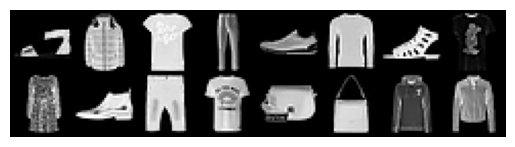

In [5]:
# Plot some images
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis("off")
    plt.show()
    
# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show image
imshow(torchvision.utils.make_grid(images[:16]))

In [6]:
# Define model
class AutoEncoder(nn.Module):
  def __init__(self, in_dim, n_channels, encoding_dim):
    super(AutoEncoder, self).__init__()

    # Parameters
    self.dim = in_dim
    self.channels = n_channels
    self.encoding_dim = encoding_dim

    # Encoder
    self.enc_fc1 = nn.Linear(self.dim * self.dim, self.encoding_dim)
    self.enc_fc2 = nn.Linear(self.encoding_dim, self.encoding_dim // 2)
    self.enc_fc3 = nn.Linear(self.encoding_dim // 2, self.encoding_dim // 4)

    # Decoder
    self.dec_fc1 = nn.Linear(self.encoding_dim // 4, self.encoding_dim // 2)
    self.dec_fc2 = nn.Linear(self.encoding_dim // 2, self.encoding_dim)
    self.dec_fc3 = nn.Linear(self.encoding_dim, self.dim * self.dim)

    # Activation
    self.relu = nn.ReLU()
  
  def forward(self, x):
    # Flatten image
    y = x.reshape(-1, self.dim * self.dim)

    # Pass through the encoder
    y = self.relu(self.enc_fc1(y))
    y = self.relu(self.enc_fc2(y))
    y = self.relu(self.enc_fc3(y))

    # Reconstruct using decoder
    y = self.relu(self.dec_fc1(y))
    y = self.relu(self.dec_fc2(y))
    y = torch.sigmoid(self.dec_fc3(y)) # sigmoid forces output to range [0, 1]
    return y

In [7]:
IN_DIM = 28
N_CHANNELS = 1
ENCODING_DIM = 64
vanilla_ae = AutoEncoder(IN_DIM, N_CHANNELS, ENCODING_DIM)
vanilla_ae = vanilla_ae.to(device)

In [8]:
# Optimizer and Loss function
criterion = nn.MSELoss() # Loss Function
optimizer = torch.optim.Adam(vanilla_ae.parameters(), lr=0.01) # Optimizer 

In [9]:
def train_step(model, train_loader, optimizer, criterion):
  model.train()
  epoch_loss = []
  total, correct = 0, 0

  for i, batch in tqdm(enumerate(train_loader), 
                       total=len(train_loader),
                       leave=False,
                       ):
    images, labels = batch
    images = images.to(device)

    optimizer.zero_grad() # Erase history - clean slate

    reconstruction = model(images) 
    loss = criterion(reconstruction, images.reshape(-1, IN_DIM*IN_DIM))
    epoch_loss.append(loss.item())

    loss.backward() # backward pass
    optimizer.step() # Update the weights using gradients
  
  return np.mean(epoch_loss)

In [10]:
def valid_step(model, val_loader, criterion):
  model.eval()
  epoch_loss = []
  total, correct = 0, 0

  with torch.no_grad():
    for i, batch in tqdm(enumerate(val_loader), 
                        total=len(val_loader),
                        leave=False,
                        ):
      images, labels = batch
      images = images.to(device)

      reconstruction = model(images) 
      loss = criterion(reconstruction, images.reshape(-1, IN_DIM*IN_DIM))
      epoch_loss.append(loss.item())
  
  return np.mean(epoch_loss)

In [11]:
# training loop
EPOCHS = 20
losses = {"train_loss": [], "val_loss": []}
epochs = []
for epoch in tqdm(range(EPOCHS), total=EPOCHS):
  train_loss = train_step(vanilla_ae, 
                          trainloader, 
                          optimizer, 
                          criterion,)
  
  val_loss = valid_step(vanilla_ae, 
                        testloader, 
                        criterion,
                        )
  
  losses["train_loss"].append(train_loss)
  losses["val_loss"].append(val_loss)
  epochs.append(epoch)

  print(f'[{epoch + 1}] train loss: {train_loss}  val loss: {val_loss}')

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

[1] train loss: 0.029593515239640086  val loss: 0.02290135389490492


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

[2] train loss: 0.0218453960818872  val loss: 0.021255491064137714


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

[3] train loss: 0.020776004975300227  val loss: 0.020496418557254373


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

[4] train loss: 0.02049963687782857  val loss: 0.020191344723200343


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

[5] train loss: 0.02016622922631469  val loss: 0.020125233467407286


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

[6] train loss: 0.020041793926374743  val loss: 0.019795704899937105


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

[7] train loss: 0.019906789940128577  val loss: 0.020410970956751495


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

[8] train loss: 0.019795459073616753  val loss: 0.01966066042756199


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

[9] train loss: 0.019790602664250746  val loss: 0.019902597994181762


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

[10] train loss: 0.019613554465896223  val loss: 0.01996866317026934


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

[11] train loss: 0.01957596499703205  val loss: 0.019606481869794003


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

[12] train loss: 0.01956297727083283  val loss: 0.019487976316054156


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

[13] train loss: 0.01942725282218029  val loss: 0.01970936922700542


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

[14] train loss: 0.019225138235590987  val loss: 0.01951791823005221


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

[15] train loss: 0.01918594255201471  val loss: 0.01913836159428973


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

[16] train loss: 0.01906147813583329  val loss: 0.019097524529002655


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

[17] train loss: 0.019017314712113854  val loss: 0.019562990440257416


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

[18] train loss: 0.018977967371890093  val loss: 0.018722971984345443


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

[19] train loss: 0.01895116965300334  val loss: 0.01927441215605303


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

[20] train loss: 0.01883056344114927  val loss: 0.019311470993954666


Text(0.5, 1.0, 'Loss vs Epochs')

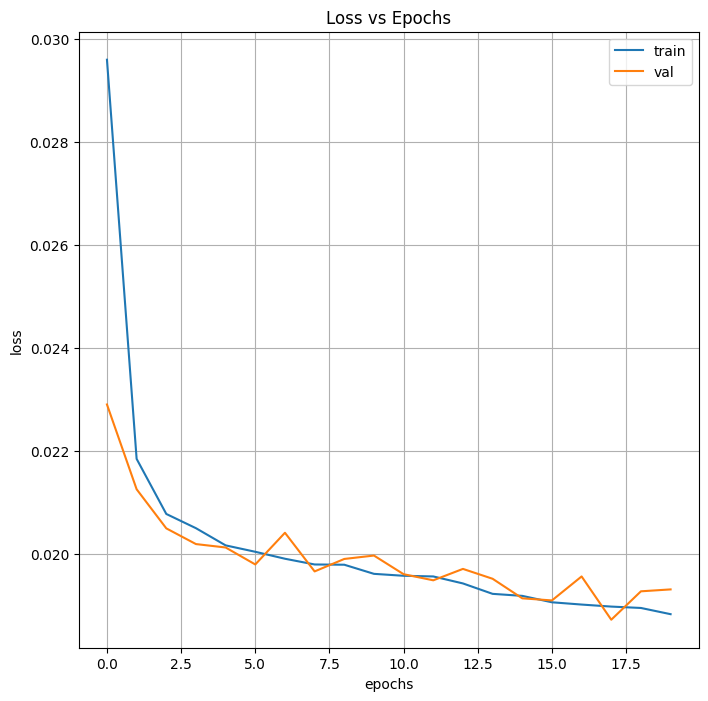

In [12]:
# Plot loss
plt.figure(figsize=(8,8))
plt.plot(epochs, losses["train_loss"], label="train")
plt.plot(epochs, losses["val_loss"], label="val")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.grid("on")
plt.legend()
plt.title("Loss vs Epochs");

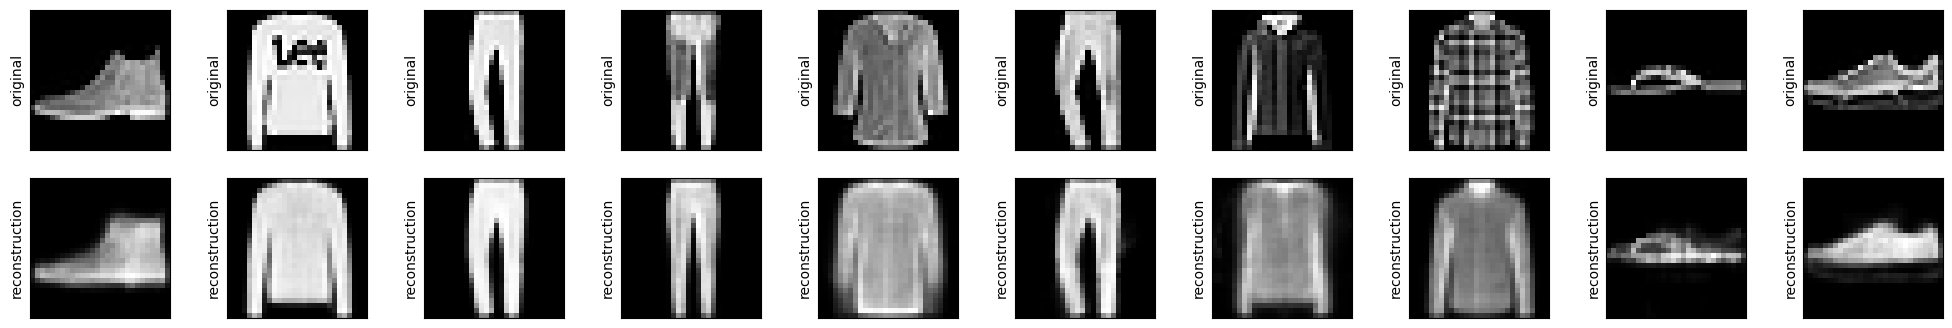

In [13]:
# Visualize reconstructions
# obtain one batch of test images
dataiter = iter(testloader)
images, labels = next(dataiter)

images_flatten = images[:10].view(-1, IN_DIM)
# get reconstruction
with torch.no_grad():
  output = vanilla_ae(images_flatten.to(device))

images = images[:10].numpy()
output = output.view(10, 1, 28, 28)
output = output.detach().cpu().numpy()

# plot images and their reconstructions
fig, axes = plt.subplots(nrows=2, 
                         ncols=10, 
                         sharex=True, 
                         sharey=True, figsize=(25,4))

# input images on top row, reconstructions on bottom
titles = ['original', 'reconstruction']
for images, row, title in zip([images, output], axes, titles):
    for img, ax in zip(images, row):
        ax.imshow(np.squeeze(img), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.set_ylabel(title)
        ax.set_yticks([])
        ax.set_yticklabels([])
        

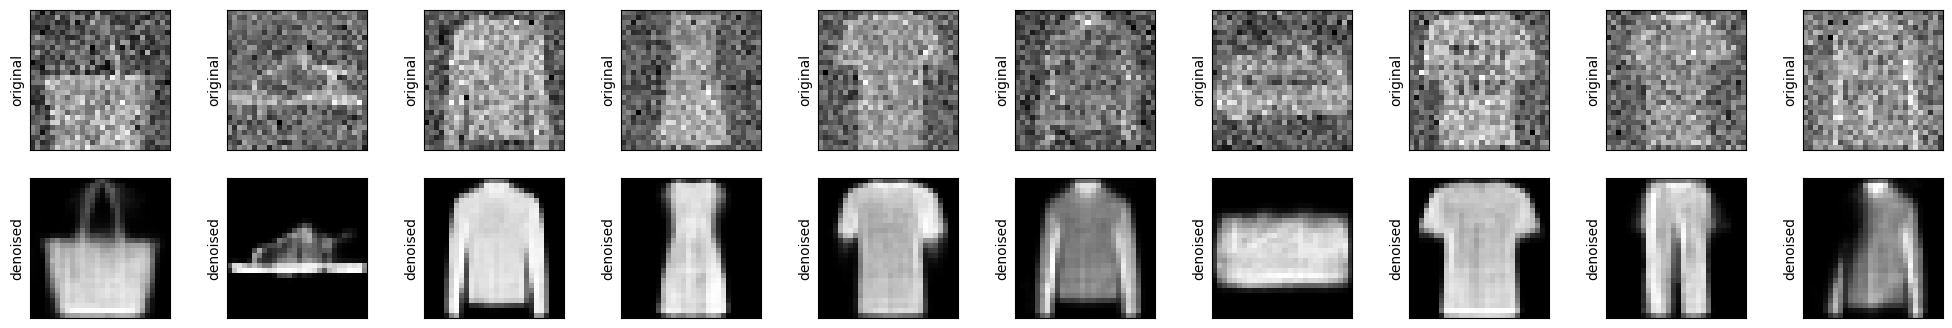

In [21]:
# Denoising
dataiter = iter(testloader)
for _ in range(5):
  images, labels = next(dataiter)

images = images + 0.3* torch.randn(images.size())

images_flatten = images[:10].view(-1, IN_DIM)
# get reconstruction
with torch.no_grad():
  output = vanilla_ae(images_flatten.to(device))

images = images[:10].numpy()
output = output.view(10, 1, 28, 28)
output = output.detach().cpu().numpy()

# plot images and their reconstructions
fig, axes = plt.subplots(nrows=2, 
                         ncols=10, 
                         sharex=True, 
                         sharey=True, figsize=(25,4))

# input images on top row, reconstructions on bottom
titles = ['original', 'denoised']
for images, row, title in zip([images, output], axes, titles):
    for img, ax in zip(images, row):
        ax.imshow(np.squeeze(img), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.set_ylabel(title)
        ax.set_yticks([])
        ax.set_yticklabels([])
        